In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../new_modules')
import ObsModels

import FSC as controller

In [10]:
import torch
import copy

# Experimental simulation

In [4]:
ActSpace = np.array(["Act 0", "Act 1"])
MemSpace = np.array(["Mem 0", "Mem 1"])

M = len(MemSpace)
A = len(ActSpace)

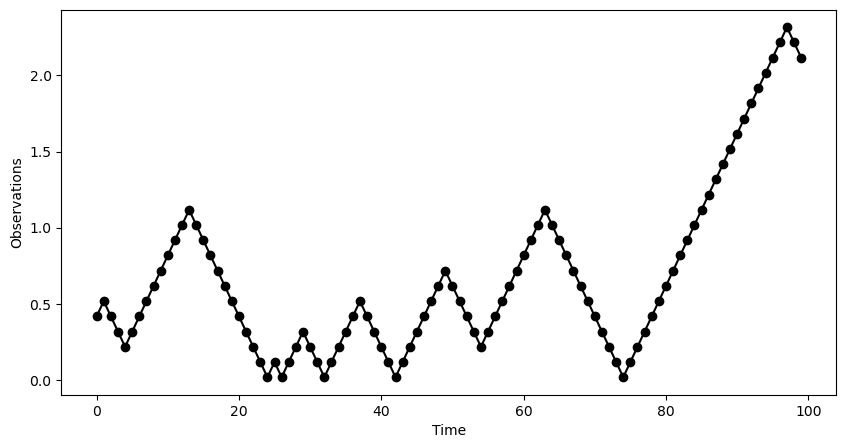

In [103]:
NSteps = 100
NTraj = 100

rate = 0.1
mplus = 0.1
mminus = -0.1
dt = 1
y0 = 1

observations = ObsModels.LinearRamps(NTraj, NSteps, rate, mplus, mminus, dt, initial_seed = 1)

features = []

for i in range(NTraj):
    features.append(np.array([np.ones(NSteps), observations[i]]))


fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [104]:
M = 2
A = 2

F = features[0].shape[0]

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC_exp = controller.FSC("continuous", M = 2, A = 2, F = F, mode = "generation", seed = 42,
                         psi = Psi, theta = ThetaFollowSwitch,
                         ActSpace = ActSpace, MemSpace = MemSpace)

In [105]:
FSC_exp.load_features(features)

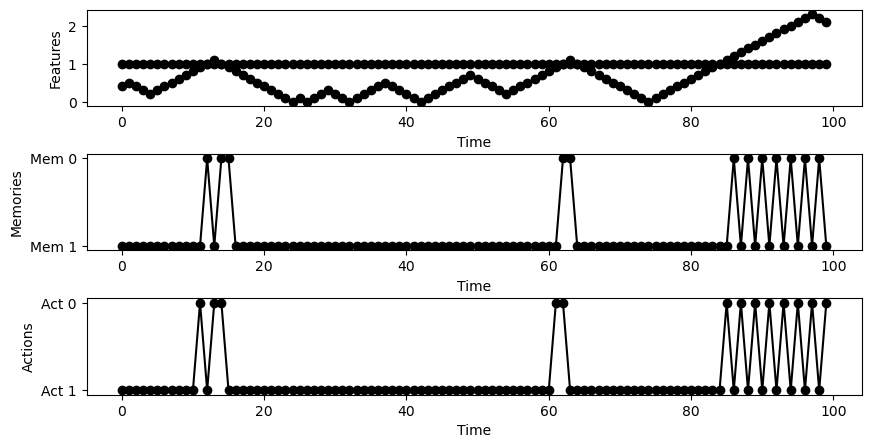

In [106]:
experimental_trajectories = FSC_exp.generate_trajectories(NSteps = NSteps)

idx_trj = 0
trj = experimental_trajectories[idx_trj]
fig, ax = FSC_exp.generator.plot_trajectory(trj)

In [107]:
experimental_trajectories_all = copy.deepcopy(experimental_trajectories)

for trj in experimental_trajectories:
    del trj["memories"]

In [108]:
nLL = 0

for trj in experimental_trajectories_all:
    nLL += FSC_exp.generator.evaluate_nloglikelihood(trj)

nLL/len(experimental_trajectories_all)

12.381856396294332

# Use-case example

In [109]:
FSC = controller.FSC("continuous", M = 2, A = 2, F = 2, seed = 42,
                     ActSpace = ActSpace, MemSpace = MemSpace)

In [110]:
NEpochs = 30
NBatch = 20
lr = (0.05, 0.05)
gamma = 0.99

tloss, vloss = FSC.fit(experimental_trajectories,
                       NEpochs = NEpochs, NBatch = NBatch, lr = lr, gamma = gamma)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 70.81295471191406, Validation loss: 61.25271339416504 - Learning rate: 0.05
Epoch 2 - Training loss: 57.056042480468754, Validation loss: 46.90566062927246 - Learning rate: 0.0495
Epoch 3 - Training loss: 46.37673416137695, Validation loss: 40.18829011917114 - Learning rate: 0.049005
Epoch 4 - Training loss: 42.178662872314455, Validation loss: 37.81599164009094 - Learning rate: 0.04851495
Epoch 5 - Training loss: 40.48510665893555, Validation loss: 36.45487670898437 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 39.146943664550776, Validation loss: 35.2697678565979 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 37.73778228759765, Validation loss: 34.15239264965057 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 36.66537246704102, Validation loss: 33.252033424377444 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 35.88975067138672, Validation loss: 32.74

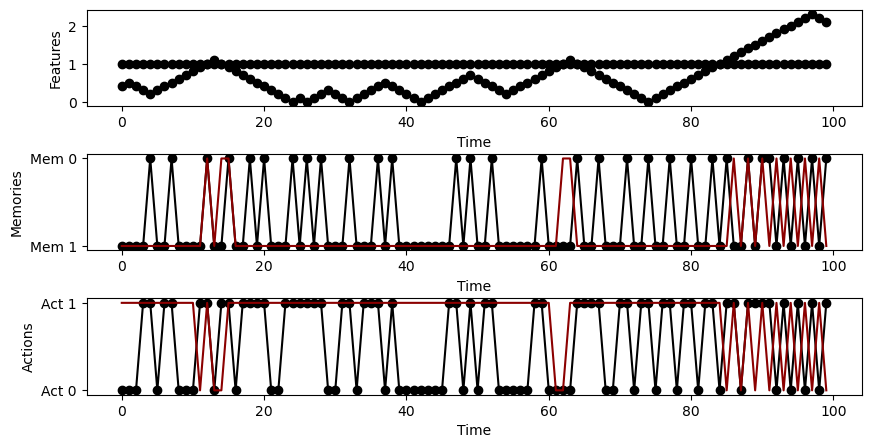

In [111]:
FSC.set_mode("generation")

generated_trajectories = FSC.generate_trajectories(NSteps)

idx_trj = 0
trj = generated_trajectories[idx_trj]
fig, ax = FSC.generator.plot_trajectory(trj)

ax[1].plot(experimental_trajectories_all[idx_trj]["memories"], label='Experimental', color='darkred')
ax[2].plot(experimental_trajectories_all[idx_trj]["actions"], label='Experimental', color='darkred')
plt.show()